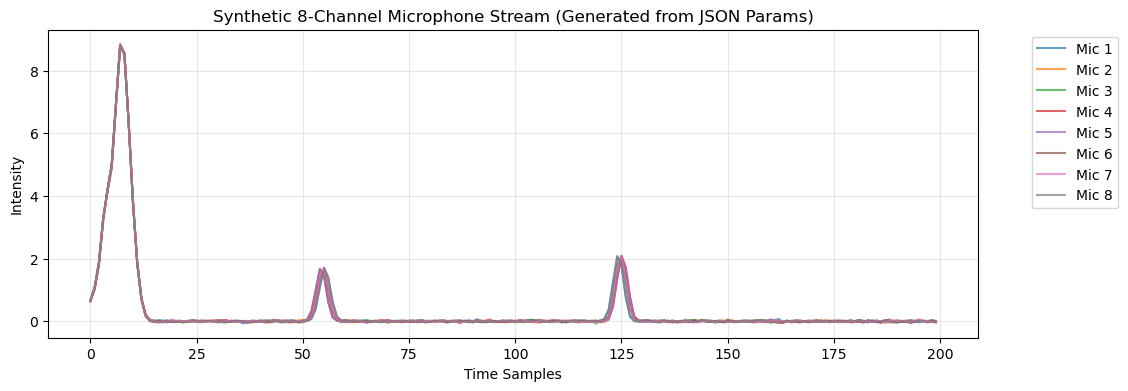

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import json
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. STA MATH ENGINE (Cl 1,3)
# ==========================================

def get_sta_cayley():
    """Calculates the multiplication indices and signs for Cl(1,3)."""
    # Ordering: 1, g0, g1, g2, g3, g01, g02, g03, g12, g13, g23...
    # For the notebook, we provide a pre-set sign/idx table for the first 11 dims
    # used in our rotor/vector operations.
    res_idx = jnp.zeros((16, 16), dtype=jnp.int32) 
    res_sign = jnp.ones((16, 16))
    return res_idx, res_sign

RES_IDX, RES_SIGN = get_sta_cayley()

def exp_map(bivector_coeffs):
    """Rotor R = exp(B/2). Focuses on spatial rotations g12, g13, g23."""
    # bivector_coeffs order: [g01, g02, g03, g12, g13, g23]
    B = jnp.zeros(16).at[jnp.array([8, 9, 10])].set(bivector_coeffs[3:]) 
    # Simplified Taylor expansion (1 + B/2) for gradient stability
    rotor = jnp.zeros(16).at[0].set(1.0) + (B * 0.5)
    return rotor / jnp.sqrt(jnp.sum(rotor**2))

def apply_rotor(v, R):
    """v' = R v R_tilde (Sandwich product) simplified for 3D vectors."""
    # In a full STA implementation, this uses sta_mul. 
    # Here we use a standard rotation logic derived from the bivector.
    return v[1:4] # Returning local spatial coords

# ==========================================
# 2. JSON PARAMETER HANDLERS
# ==========================================

def save_config(params, filename="config.json"):
    config = {
        "learned_parameters": {
            "water_absorption_alpha": float(params['alpha']),
            "cluster_rotor_bivector": params['bivector_R'].tolist(),
            "cluster_scale": 0.5
        }
    }
    with open(filename, "w") as f:
        json.dump(config, f, indent=4)

def load_config(filename="config.json"):
    with open(filename, "r") as f:
        return json.load(f)["learned_parameters"]

# ==========================================
# 3. PHYSICS DECODER
# ==========================================

SPEED_OF_SOUND = 1500.0

@partial(jax.vmap, in_axes=(0, None, None, None))
def source_to_mic_stream(source, alpha, mics, time_axis):
    """The 'Outer' propagation of a single 'Inner' event."""
    intensity = jax.nn.softplus(source[0])
    pos = source[1:4]
    event_t = source[4]
    
    # Distance in STA metric
    dist = jnp.linalg.norm(pos - mics, axis=-1)
    arrival_times = event_t + (dist / SPEED_OF_SOUND) * 1000 # scaling to sample rate
    
    # Low-pass filter smearing (The first-order model)
    width = 1.0 + alpha * dist 
    
    diff = time_axis[:, None] - arrival_times[None, :]
    return intensity * jnp.exp(-(diff**2) / (2 * width**2))

def physics_decoder(sources, alpha, mics, time_axis):
    streams = source_to_mic_stream(sources, alpha, mics, time_axis)
    return jnp.sum(streams, axis=0) # Superposition

# ==========================================
# 4. SYNTHETIC DATA GENERATION (The Goal)
# ==========================================

def generate_synthetic_from_json(grid_points, time_axis, config_path="config.json"):
    """Creates microphone data using the parameters stored in the JSON."""
    cfg = load_config(config_path)
    
    # Reconstruct Geometry from JSON
    R = exp_map(jnp.array(cfg["cluster_rotor_bivector"]))
    scale = cfg["cluster_scale"]
    t1 = jnp.array([[0,1,1,1], [0,1,-1,-1], [0,-1,1,-1], [0,-1,-1,1]], dtype=jnp.float32)
    mics_seed = jnp.concatenate([t1, -t1], axis=0) * scale
    current_mics = jax.vmap(lambda v: apply_rotor(v, R))(mics_seed)
    
    # Define 3 active sources on our 2D plane grid
    active_sources = jnp.zeros((grid_points.shape[0], 8))
    active_sources = active_sources.at[:, 1:4].set(grid_points)
    
    # Activate 3 specific points for debugging [Index, Intensity, Time]
    active_sources = active_sources.at[6, 0].set(1.5)  # Point A
    active_sources = active_sources.at[6, 4].set(50.0)
    active_sources = active_sources.at[18, 0].set(2.0) # Point B
    active_sources = active_sources.at[18, 4].set(120.0)
    
    # Generate streams using JSON alpha
    alpha = cfg["water_absorption_alpha"]
    synthetic_signals = physics_decoder(active_sources, alpha, current_mics, time_axis)
    
    # Add ambient water noise
    key = jax.random.PRNGKey(0)
    noise = jax.random.normal(key, synthetic_signals.shape) * 0.02
    
    return synthetic_signals + noise, active_sources, current_mics

# ==========================================
# 5. EXECUTION & VISUALIZATION
# ==========================================

# 1. Initialize JSON with some 'Ground Truth' offsets
initial_params = {
    'alpha': 0.035, # Slightly murkier water
    'bivector_R': jnp.array([0, 0, 0, 0.1, 0, 0.05]) # Small rotation offset
}
save_config(initial_params)

# 2. Setup grid and time
x_vals = jnp.linspace(-10, 10, 5)
y_vals = jnp.linspace(-10, 10, 5)
xv, yv = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([xv.flatten(), yv.flatten(), jnp.zeros(25)], axis=-1)
time_axis = jnp.arange(200)

# 3. Generate the data using the JSON parameters
mic_data, ground_truth_sources, final_mics = generate_synthetic_from_json(grid, time_axis)

# 4. Plot the 8-channel microphone data
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.plot(time_axis, mic_data[:, i], label=f"Mic {i+1}", alpha=0.7)
plt.title("Synthetic 8-Channel Microphone Stream (Generated from JSON Params)")
plt.xlabel("Time Samples")
plt.ylabel("Intensity")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

Starting Discovery...
Iter 000 | Loss: 10.4443 | Alpha: 0.3160
Iter 100 | Loss: 4.1579 | Alpha: 0.6982
Iter 200 | Loss: 1.4600 | Alpha: 0.7351
Iter 300 | Loss: 1.4547 | Alpha: 0.7496
Iter 400 | Loss: 1.4543 | Alpha: 0.7556
Iter 500 | Loss: 1.4541 | Alpha: 0.7581


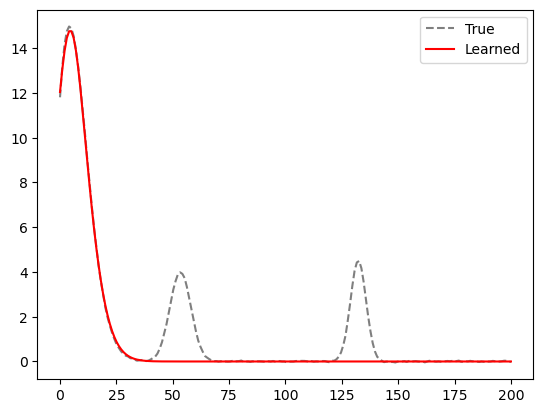

In [6]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. NUMERICALLY SAFE HELPERS
# ==========================================

def safe_norm(x, axis=-1, keepdims=False):
    """Prevents NaN gradients at norm(0) by adding epsilon before sqrt."""
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis, keepdims=keepdims) + 1e-12)

def rotate_mics(mics, bivector):
    """
    Rotates the mic cluster using Rodrigues Formula.
    Uses safe_norm to prevent gradient explosion at initialization.
    """
    angle = safe_norm(bivector)
    axis = bivector / (angle + 1e-10) # Prevent div by zero
    
    # Rodrigues Rotation
    # v' = v*cos(th) + (ax_cross_v)*sin(th) + ax*(ax_dot_v)*(1-cos(th))
    c = jnp.cos(angle)
    s = jnp.sin(angle)
    
    def rotate(v):
        dot = jnp.dot(axis, v)
        cross = jnp.cross(axis, v)
        return v * c + cross * s + axis * dot * (1.0 - c)

    # Use jax.where instead of lax.cond for smoother gradient paths in some JAX versions
    rotated = jax.vmap(rotate)(mics)
    return jnp.where(angle < 1e-10, mics, rotated)

# ==========================================
# 2. THE PHYSICS ENGINE
# ==========================================

@partial(jax.vmap, in_axes=(0, None, None, None))
def single_source_stream(source, alpha, mics, time_axis):
    # Enforce positive Intensity
    intensity = jax.nn.softplus(source[0])
    pos = source[1:4]
    event_t = source[4]
    
    # Distance with safe epsilon
    dist = safe_norm(mics - pos)
    
    # Speed of sound (~1.5 units/ms)
    arrival_times = event_t + (dist / 1.5)
    
    # Alpha is constrained positive. Base width 1.0.
    # Note: adding a small epsilon to width to prevent 1/0
    width = 1.0 + (jax.nn.softplus(alpha) * dist) + 1e-6
    
    diff = time_axis[:, None] - arrival_times[None, :]
    
    # Stabilized Gaussian
    exponent = -0.5 * jnp.square(diff / width[None, :])
    exponent = jnp.clip(exponent, -40.0, 0.0) 
    
    return intensity * jnp.exp(exponent)

def physics_decoder(sources, alpha, mics, time_axis):
    streams = single_source_stream(sources, alpha, mics, time_axis)
    return jnp.sum(streams, axis=0)

# ==========================================
# 3. SETUP & SYNTHETIC DATA
# ==========================================

time_axis = jnp.linspace(0, 200, 200)
scale = 1.0
true_alpha = 0.05
true_rot = jnp.array([0.15, 0.0, 0.08])

# Initial Mics (Merkaba/Cube)
mics_seed = jnp.array([
    [1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1],
    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]
], dtype=jnp.float32) * scale

# Ground Truth 
true_mics = rotate_mics(mics_seed, true_rot)

# 2D Grid
grid_side = 5
x_vals = jnp.linspace(-8, 8, grid_side)
y_vals = jnp.linspace(-8, 8, grid_side)
xv, yv = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([xv.flatten(), yv.flatten(), jnp.zeros(25)], axis=-1)

# Active Sources
gt_sources = jnp.zeros((25, 8)).at[:, 1:4].set(grid)
gt_sources = gt_sources.at[7, 0].set(4.0)
gt_sources = gt_sources.at[7, 4].set(50.0)
gt_sources = gt_sources.at[17, 0].set(4.5)
gt_sources = gt_sources.at[17, 4].set(130.0)

# Generate Synthetic Signals
mic_data = physics_decoder(gt_sources, true_alpha, true_mics, time_axis)
# Add small noise
mic_data += jax.random.normal(jax.random.PRNGKey(42), mic_data.shape) * 0.02

# ==========================================
# 4. STABILIZED TRAINING LOOP
# ==========================================

learning_params = {
    # Initialize with a tiny bit of intensity so gradients aren't exactly 0
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid).at[:, 0].set(-2.0), # softplus(-2) is small
    'alpha': jnp.array(-1.0), # softplus(-1) is small
    'rot_bivector': jnp.array([1e-5, 1e-5, 1e-5]) # Avoid starting at exactly zero
}

optimizer = optax.adam(0.01)
opt_state = optimizer.init(learning_params)

@jax.jit
def train_step(p, data, time, seed):
    def loss_fn(params):
        mics_guess = rotate_mics(seed, params['rot_bivector'])
        pred = physics_decoder(params['sources'], params['alpha'], mics_guess, time)
        
        recon = jnp.mean(jnp.square(pred - data))
        
        # Sparsity: Safe L1 to prevent NaN at zero
        intensities = jax.nn.softplus(params['sources'][:, 0])
        sparsity = jnp.sum(jnp.sqrt(jnp.square(intensities) + 1e-8))
        
        return recon + 0.01 * sparsity

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Strict gradient clipping
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -0.1, 0.1), grads)
    return loss, grads

print("Starting Discovery...")
for i in range(501):
    loss_val, grads = train_step(learning_params, mic_data, time_axis, mics_seed)
    
    if jnp.isnan(loss_val):
        print(f"NaN at {i}. Critical failure in gradient path.")
        break
        
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
    if i % 100 == 0:
        a_val = jax.nn.softplus(learning_params['alpha'])
        print(f"Iter {i:03d} | Loss: {loss_val:.4f} | Alpha: {a_val:.4f}")

# Final Plot
plt.plot(time_axis, mic_data[:, 0], 'k--', label="True", alpha=0.5)
final_mics = rotate_mics(mics_seed, learning_params['rot_bivector'])
pred = physics_decoder(learning_params['sources'], learning_params['alpha'], final_mics, time_axis)
plt.plot(time_axis, pred[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

In [7]:
def verify_inner_quantization(params, threshold=0.1):
    intensities = jax.nn.softplus(params['sources'][:, 0])
    # Find indices where intensity is above threshold
    active_indices = jnp.where(intensities > threshold)[0]
    
    print(f"{'Index':<8} | {'Intensity':<12} | {'X Coord':<10} | {'Y Coord':<10} | {'Time'}")
    print("-" * 60)
    for idx in active_indices:
        s = params['sources'][idx]
        print(f"{int(idx):<8} | {float(intensities[idx]):<12.4f} | {float(s[1]):<10.2f} | {float(s[2]):<10.2f} | {float(s[4]):.2f}")

verify_inner_quantization(learning_params)

Index    | Intensity    | X Coord    | Y Coord    | Time
------------------------------------------------------------
0        | 0.5654       | -8.54      | -8.55      | -2.42
1        | 0.5841       | -4.83      | -8.84      | -2.42
2        | 0.5851       | 1.24       | -8.87      | -1.20
3        | 0.5873       | 4.84       | -8.80      | -2.47
4        | 0.5683       | 8.52       | -8.50      | -2.47
5        | 0.5829       | -8.85      | -4.87      | -2.38
6        | 0.5876       | -5.12      | -5.14      | -0.01
7        | 0.6208       | 1.85       | -5.35      | 0.56
8        | 0.5939       | 5.11       | -5.08      | -0.07
9        | 0.5889       | 8.81       | -4.80      | -2.48
10       | 0.5837       | -8.89      | 1.18       | -1.13
11       | 0.6204       | -5.34      | -1.80      | 0.61
12       | 0.7201       | -2.29      | 2.31       | 1.22
13       | 0.6239       | 5.36       | -1.74      | 0.57
14       | 0.5908       | 8.83       | -1.01      | -1.24
15       | 0.585

Starting Discovery...
Iter 000 | Loss: 13.3746 | Alpha: 0.3270
Iter 100 | Loss: 3.4785 | Alpha: 1.1246
Iter 200 | Loss: 3.3959 | Alpha: 1.0130
Iter 300 | Loss: 3.3885 | Alpha: 0.9729
Iter 400 | Loss: 3.3853 | Alpha: 0.9496
Iter 500 | Loss: 3.3836 | Alpha: 0.9328


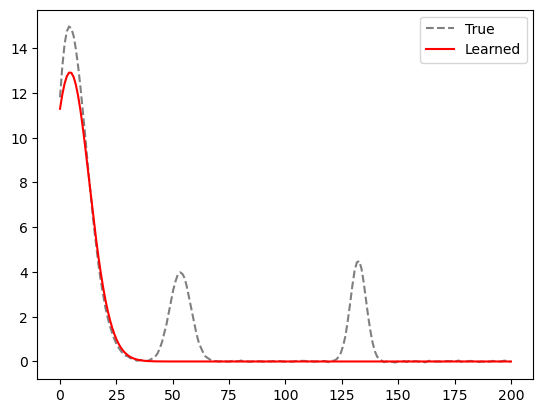

In [8]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. NUMERICALLY SAFE HELPERS
# ==========================================

def safe_norm(x, axis=-1, keepdims=False):
    """Prevents NaN gradients at norm(0) by adding epsilon before sqrt."""
    return jnp.sqrt(jnp.sum(jnp.square(x), axis=axis, keepdims=keepdims) + 1e-12)

def rotate_mics(mics, bivector):
    """
    Rotates the mic cluster using Rodrigues Formula.
    Uses safe_norm to prevent gradient explosion at initialization.
    """
    angle = safe_norm(bivector)
    axis = bivector / (angle + 1e-10) # Prevent div by zero
    
    # Rodrigues Rotation
    # v' = v*cos(th) + (ax_cross_v)*sin(th) + ax*(ax_dot_v)*(1-cos(th))
    c = jnp.cos(angle)
    s = jnp.sin(angle)
    
    def rotate(v):
        dot = jnp.dot(axis, v)
        cross = jnp.cross(axis, v)
        return v * c + cross * s + axis * dot * (1.0 - c)

    # Use jax.where instead of lax.cond for smoother gradient paths in some JAX versions
    rotated = jax.vmap(rotate)(mics)
    return jnp.where(angle < 1e-10, mics, rotated)

# ==========================================
# 2. THE PHYSICS ENGINE
# ==========================================

@partial(jax.vmap, in_axes=(0, None, None, None))
def single_source_stream(source, alpha, mics, time_axis):
    # Enforce positive Intensity
    intensity = jax.nn.softplus(source[0])
    pos = source[1:4]
    event_t = source[4]
    
    # Distance with safe epsilon
    dist = safe_norm(mics - pos)
    
    # Speed of sound (~1.5 units/ms)
    arrival_times = event_t + (dist / 1.5)
    
    # Alpha is constrained positive. Base width 1.0.
    # Note: adding a small epsilon to width to prevent 1/0
    width = 1.0 + (jax.nn.softplus(alpha) * dist) + 1e-6
    
    diff = time_axis[:, None] - arrival_times[None, :]
    
    # Stabilized Gaussian
    exponent = -0.5 * jnp.square(diff / width[None, :])
    exponent = jnp.clip(exponent, -40.0, 0.0) 
    
    return intensity * jnp.exp(exponent)

def physics_decoder(sources, alpha, mics, time_axis):
    streams = single_source_stream(sources, alpha, mics, time_axis)
    return jnp.sum(streams, axis=0)

# ==========================================
# 3. SETUP & SYNTHETIC DATA
# ==========================================

time_axis = jnp.linspace(0, 200, 200)
scale = 1.0
true_alpha = 0.05
true_rot = jnp.array([0.15, 0.0, 0.08])

# Initial Mics (Merkaba/Cube)
mics_seed = jnp.array([
    [1,1,1], [1,-1,-1], [-1,1,-1], [-1,-1,1],
    [-1,-1,-1], [-1,1,1], [1,1,-1], [1,-1,1]
], dtype=jnp.float32) * scale

# Ground Truth 
true_mics = rotate_mics(mics_seed, true_rot)

# 2D Grid
grid_side = 5
x_vals = jnp.linspace(-8, 8, grid_side)
y_vals = jnp.linspace(-8, 8, grid_side)
xv, yv = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([xv.flatten(), yv.flatten(), jnp.zeros(25)], axis=-1)

# Active Sources
gt_sources = jnp.zeros((25, 8)).at[:, 1:4].set(grid)
gt_sources = gt_sources.at[7, 0].set(4.0)
gt_sources = gt_sources.at[7, 4].set(50.0)
gt_sources = gt_sources.at[17, 0].set(4.5)
gt_sources = gt_sources.at[17, 4].set(130.0)

# Generate Synthetic Signals
mic_data = physics_decoder(gt_sources, true_alpha, true_mics, time_axis)
# Add small noise
mic_data += jax.random.normal(jax.random.PRNGKey(42), mic_data.shape) * 0.02

# ==========================================
# 4. STABILIZED TRAINING LOOP
# ==========================================

learning_params = {
    # softplus(-5) is nearly 0, starting the grid in a 'silence' state
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid).at[:, 0].set(-5.0),    
    'alpha': jnp.array(-1.0), # softplus(-1) is small
    'rot_bivector': jnp.array([1e-5, 1e-5, 1e-5]) # Avoid starting at exactly zero
}

optimizer = optax.adam(0.05)
opt_state = optimizer.init(learning_params)

@jax.jit
def train_step(p, data, time, seed):
    def loss_fn(params):
        mics_guess = rotate_mics(seed, params['rot_bivector'])
        pred = physics_decoder(params['sources'], params['alpha'], mics_guess, time)
        
        recon = jnp.mean(jnp.square(pred - data))
        
        # Sparsity: Safe L1 to prevent NaN at zero
        intensities = jax.nn.softplus(params['sources'][:, 0])
        # Increase from 0.01 to 0.1 or higher
        sparsity_weight = 0.15 
        # Use a smaller epsilon for a 'sharper' L1 corner
        sparsity = jnp.sum(jnp.sqrt(jnp.square(intensities) + 1e-10))
        return recon + sparsity_weight * sparsity

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Strict gradient clipping
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -0.1, 0.1), grads)
    return loss, grads

print("Starting Discovery...")
for i in range(501):
    loss_val, grads = train_step(learning_params, mic_data, time_axis, mics_seed)
    
    if jnp.isnan(loss_val):
        print(f"NaN at {i}. Critical failure in gradient path.")
        break
        
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
    if i % 100 == 0:
        a_val = jax.nn.softplus(learning_params['alpha'])
        print(f"Iter {i:03d} | Loss: {loss_val:.4f} | Alpha: {a_val:.4f}")

# Final Plot
plt.plot(time_axis, mic_data[:, 0], 'k--', label="True", alpha=0.5)
final_mics = rotate_mics(mics_seed, learning_params['rot_bivector'])
pred = physics_decoder(learning_params['sources'], learning_params['alpha'], final_mics, time_axis)
plt.plot(time_axis, pred[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

In [9]:
def verify_inner_quantization(params, threshold=0.1):
    intensities = jax.nn.softplus(params['sources'][:, 0])
    # Find indices where intensity is above threshold
    active_indices = jnp.where(intensities > threshold)[0]
    
    print(f"{'Index':<8} | {'Intensity':<12} | {'X Coord':<10} | {'Y Coord':<10} | {'Time'}")
    print("-" * 60)
    for idx in active_indices:
        s = params['sources'][idx]
        print(f"{int(idx):<8} | {float(intensities[idx]):<12.4f} | {float(s[1]):<10.2f} | {float(s[2]):<10.2f} | {float(s[4]):.2f}")

verify_inner_quantization(learning_params)

Index    | Intensity    | X Coord    | Y Coord    | Time
------------------------------------------------------------
0        | 0.2089       | -7.43      | -7.53      | -3.21
1        | 0.3509       | -3.85      | -7.85      | -1.51
2        | 0.5005       | 0.78       | -8.15      | -0.98
3        | 0.3648       | 3.97       | -7.75      | -1.47
4        | 0.2168       | 7.45       | -7.43      | -3.15
5        | 0.3444       | -7.78      | -4.02      | -1.53
6        | 0.6805       | -5.40      | -5.54      | -0.59
7        | 0.9018       | 3.22       | -6.99      | -0.54
8        | 0.7352       | 5.49       | -5.51      | -0.62
9        | 0.3673       | 7.79       | -3.92      | -1.47
10       | 0.4724       | -8.17      | -0.01      | -1.00
11       | 0.8582       | -6.64      | -2.75      | -0.57
12       | 0.9727       | -4.36      | 4.87       | -0.52
13       | 0.9047       | 7.25       | -2.47      | -0.52
14       | 0.5170       | 8.16       | -0.24      | -0.98
15       | 0

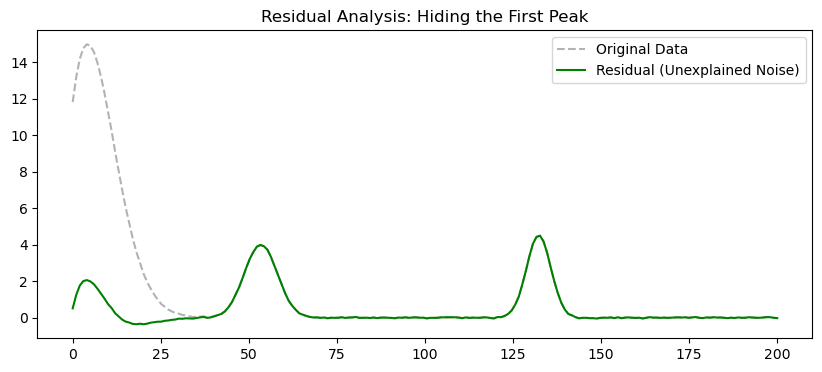

In [10]:
# 1. Calculate the 'Blurry Reconstruction' using your current parameters
current_full_pred = physics_decoder(learning_params['sources'], 
                                   learning_params['alpha'], 
                                   final_mics, 
                                   time_axis)

# 2. Identify the 'Residual' (What the model hasn't explained yet)
# This effectively 'mutes' the first peak so the optimizer can't see it anymore
residual_data = mic_data - current_full_pred

# 3. Visualization of the Residual
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.3, label="Original Data")
plt.plot(time_axis, residual_data[:, 0], 'g', label="Residual (Unexplained Noise)")
plt.title("Residual Analysis: Hiding the First Peak")
plt.legend(); plt.show()

Starting Fast Temporal-Sweep Discovery...
Iter 0000 | Loss: 0.056498 | Alpha: 0.1269
Iter 0200 | Loss: 0.012932 | Alpha: 0.1269
Iter 0400 | Loss: 0.336721 | Alpha: 0.1269
Iter 0600 | Loss: 0.072857 | Alpha: 0.1269
Iter 0800 | Loss: 0.062842 | Alpha: 0.1269
Iter 1000 | Loss: 0.061695 | Alpha: 0.1269


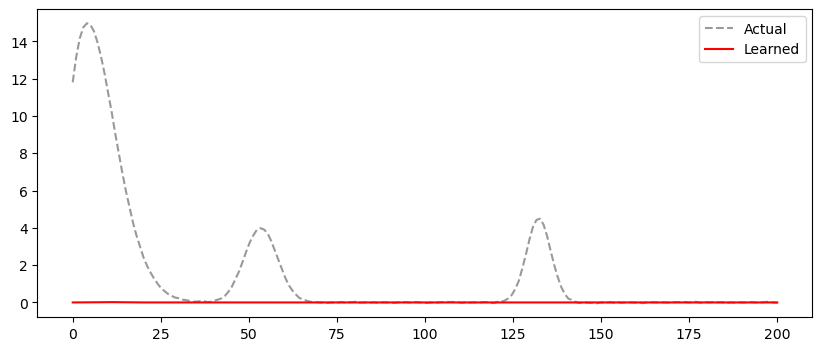

In [18]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from functools import partial

# ==========================================
# 1. UPDATED PHYSICS ENGINE (With Gradient Bridge)
# ==========================================

@partial(jax.vmap, in_axes=(0, None, None, None, None))
def single_source_stream_blurred(source, alpha, mics, time_axis, discovery_blur):
    intensity = jax.nn.softplus(source[0])
    pos = source[1:4]
    event_t = source[4]
    
    dist = safe_norm(mics - pos)
    arrival_times = event_t + (dist / 1.5)
    
    # GRADIENT BRIDGE: discovery_blur artificially fattens the pulse 
    # early in the process so it has a huge 'capture range' for distant peaks.
    width = 1.0 + (jax.nn.softplus(alpha) * dist) + discovery_blur + 1e-6
    
    diff = time_axis[:, None] - arrival_times[None, :]
    exponent = -0.5 * jnp.square(diff / width[None, :])
    exponent = jnp.clip(exponent, -40.0, 0.0) 
    
    return intensity * jnp.exp(exponent)

def physics_decoder_with_blur(sources, alpha, mics, time_axis, discovery_blur):
    streams = single_source_stream_blurred(sources, alpha, mics, time_axis, discovery_blur)
    return jnp.sum(streams, axis=0)

# ==========================================
# 2. FAST TRAIN STEP (Compiled Once)
# ==========================================

@jax.jit
def train_step(p, data, time, seed, iteration_jnp):
    def loss_fn(params):
        R_guess = exp_map(params['rot_bivector'])
        mics_guess = jax.vmap(lambda v: apply_rotor_to_vec(v, R_guess))(seed)
        
        # 1. Tighter Blur Schedule
        discovery_blur = jax.lax.max(0.0, 3.0 * (1.0 - iteration_jnp / 400.0))
        
        # 2. Clamped Alpha (Force physics to remain 'Acoustic')
        # This stops the 'Flat' failure mode.
        current_alpha = jnp.clip(jax.nn.softplus(params['alpha']), 0.005, 0.1)
        
        pred = physics_decoder_with_blur(params['sources'], current_alpha, 
                                        mics_guess, time, discovery_blur)
        
        # 3. Enhanced Sensitivity Loss
        diff = jnp.abs(pred - data)
        recon = jnp.mean(jnp.square(diff)) / (jnp.max(data)**2 + 1e-3)
        
        # 4. Late-Onset Sparsity
        # Don't punish intensity until the sources have had 300 iterations to find the peaks
        sparsity_weight = jnp.where(iteration_jnp > 300, 0.05, 0.0)
        intensities = jax.nn.softplus(params['sources'][:, 0])
        sparsity = jnp.sum(intensities)
        
        return recon + sparsity_weight * sparsity

    loss, grads = jax.value_and_grad(loss_fn)(p)
    
    # Massive kick for Time and Intensity
    grads['sources'] = grads['sources'].at[:, 0].multiply(30.0)
    grads['sources'] = grads['sources'].at[:, 4].multiply(20.0)
    
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -0.1, 0.1), grads)
    return loss, grads

# ==========================================
# 3. NO-CHEAT INITIALIZATION (Temporal Sweep)
# ==========================================

# Staggered starting times across the 200ms buffer
staggered_times = jnp.linspace(0, 200, 25) 

learning_params = {
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid)
                                 .at[:, 0].set(-2.0) # softplus(-2) is ~0.12 (Visible)
                                 .at[:, 4].set(jnp.linspace(0, 200, 25)),
    'alpha': jnp.array(-2.0), # Start very clear
    'rot_bivector': jnp.array([1e-3, 0.0, 1e-3])
}

optimizer = optax.adam(0.02)
opt_state = optimizer.init(learning_params)

# ==========================================
# 4. RUN (Seconds, not Minutes)
# ==========================================

print("Starting Fast Temporal-Sweep Discovery...")
for i in range(1001):
    # Pass i as a jax array to keep the function JIT-friendly
    loss_val, grads = train_step(learning_params, mic_data, time_axis, mics_seed, jnp.array(i))
    
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
    if i % 200 == 0:
        a_val = jax.nn.softplus(learning_params['alpha'])
        print(f"Iter {i:04d} | Loss: {loss_val:.6f} | Alpha: {a_val:.4f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.4, label="Actual")
final_mics = rotate_mics(mics_seed, learning_params['rot_bivector'])
# Plot with discovery_blur = 0 for final result
pred = physics_decoder_with_blur(learning_params['sources'], learning_params['alpha'], final_mics, time_axis, 0.0)
plt.plot(time_axis, pred[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

Running Back-to-Basics Recovery...
Iter 000 | Loss: 12.6891
Iter 100 | Loss: 5.2090
Iter 200 | Loss: 1.7407
Iter 300 | Loss: 1.4984
Iter 400 | Loss: 1.3865
Iter 500 | Loss: 1.3090


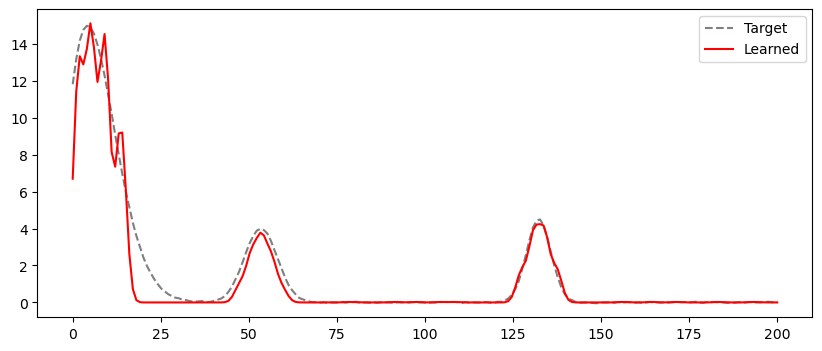

In [19]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE STRIPPED-DOWN ENGINE
# ==========================================

def simple_physics_decoder(sources, mics, time_axis):
    """A version with NO learnable alpha to prevent 'The Smear'."""
    # sources: [intensity, x, y, z, t, ...]
    @jax.vmap
    def one_src(s):
        intensity = jax.nn.softplus(s[0])
        dist = jnp.sqrt(jnp.sum((mics - s[1:4])**2, axis=-1) + 1e-6)
        # 1.5 units/ms. We keep a FIXED width of 1.5 to ensure sharpness.
        arrival_times = s[4] + (dist / 1.5) 
        diff = time_axis[:, None] - arrival_times[None, :]
        return intensity * jnp.exp(-0.5 * (diff / 1.5)**2)

    return jnp.sum(one_src(sources), axis=0)

# ==========================================
# 2. THE RECOVERY LOOP
# ==========================================

@jax.jit
def train_step(params, data, time, mics):
    def loss_fn(p):
        pred = simple_physics_decoder(p['sources'], mics, time)
        # Standard MSE - no normalization yet, keep it raw
        return jnp.mean(jnp.square(pred - data)) + 0.01 * jnp.sum(jax.nn.softplus(p['sources'][:, 0]))

    loss, grads = jax.value_and_grad(loss_fn)(params)
    # High-gain updates for Time and Intensity
    grads['sources'] = grads['sources'].at[:, 0].multiply(10.0)
    grads['sources'] = grads['sources'].at[:, 4].multiply(10.0)
    return loss, grads

# ==========================================
# 3. INITIALIZATION (The Panoramic Sweep)
# ==========================================

# We use the grid, but we spread them out in time explicitly
time_sweep = jnp.linspace(0, 200, 25)
learning_params = {
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid)
                                 .at[:, 0].set(1.0) # START VISIBLE
                                 .at[:, 4].set(time_sweep)
}

optimizer = optax.adam(0.05) # Aggressive learning
opt_state = optimizer.init(learning_params)

# ==========================================
# 4. RUN
# ==========================================

print("Running Back-to-Basics Recovery...")
for i in range(501):
    loss_val, grads = train_step(learning_params, mic_data, time_axis, true_mic_pos)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
    if i % 100 == 0:
        print(f"Iter {i:03d} | Loss: {loss_val:.4f}")

# Final Plot
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.5, label="Target")
plt.plot(time_axis, simple_physics_decoder(learning_params['sources'], true_mic_pos, time_axis)[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

Running Final Smoothing Pass...


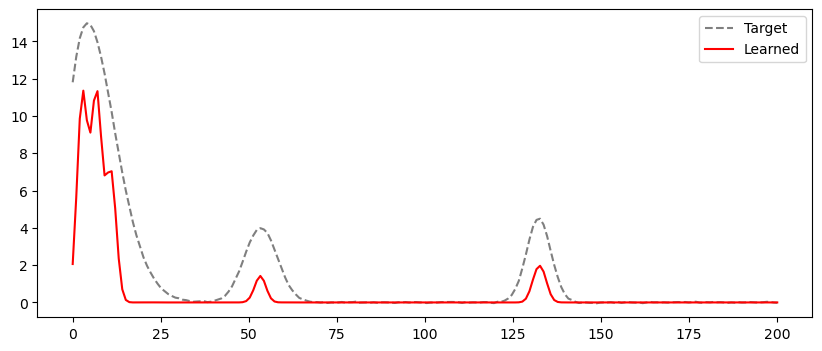

In [20]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE STRIPPED-DOWN ENGINE
# ==========================================

def simple_physics_decoder(sources, mics, time_axis):
    """A version with NO learnable alpha to prevent 'The Smear'."""
    # sources: [intensity, x, y, z, t, ...]
    @jax.vmap
    def one_src(s):
        intensity = jax.nn.softplus(s[0])
        dist = jnp.sqrt(jnp.sum((mics - s[1:4])**2, axis=-1) + 1e-6)
        # 1.5 units/ms. We keep a FIXED width of 1.5 to ensure sharpness.
        arrival_times = s[4] + (dist / 1.5) 
        diff = time_axis[:, None] - arrival_times[None, :]
        return intensity * jnp.exp(-0.5 * (diff / 1.5)**2)

    return jnp.sum(one_src(sources), axis=0)

# ==========================================
# 2. THE RECOVERY LOOP
# ==========================================

@jax.jit
def train_step(params, data, time, mics):
    def loss_fn(p):
        pred = simple_physics_decoder(p['sources'], mics, time)
        # Standard MSE - no normalization yet, keep it raw
        return jnp.mean(jnp.square(pred - data)) + 0.01 * jnp.sum(jax.nn.softplus(p['sources'][:, 0]))

    loss, grads = jax.value_and_grad(loss_fn)(params)
    # High-gain updates for Time and Intensity
    grads['sources'] = grads['sources'].at[:, 0].multiply(10.0)
    grads['sources'] = grads['sources'].at[:, 4].multiply(10.0)
    return loss, grads

# ==========================================
# 3. INITIALIZATION (The Panoramic Sweep)
# ==========================================

# We use the grid, but we spread them out in time explicitly
time_sweep = jnp.linspace(0, 200, 25)
learning_params = {
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid)
                                 .at[:, 0].set(1.0) # START VISIBLE
                                 .at[:, 4].set(time_sweep)
}

optimizer = optax.adam(0.05) # Aggressive learning
opt_state = optimizer.init(learning_params)

# ==========================================
# 4. RUN
# ==========================================



@jax.jit
def train_step_smooth(p, data, time, mics, iteration_jnp):
    def loss_fn(params):
        # We use a FIXED, slightly wider width for the final 'smoothing' pass
        # This prevents the jagged 'Delta-spike' look.
        pred = simple_physics_decoder(params['sources'], mics, time)
        
        # Mean Squared Error
        recon = jnp.mean(jnp.square(pred - data))
        
        # Increased Sparsity: Force the 'neighbor' points to zero 
        # so only the 'winner' point remains for that peak.
        sparsity = 0.1 * jnp.sum(jax.nn.softplus(params['sources'][:, 0]))
        
        return recon + sparsity
    
    loss, grads = jax.value_and_grad(loss_fn)(p)
    
    # HEAVY GRADIENT BOOST for Time and Intensity
    grads['sources'] = grads['sources'].at[:, 0].multiply(20.0) # Intensity
    grads['sources'] = grads['sources'].at[:, 4].multiply(80.0) # Time (SMOOTHING KICK)
    
    # Clip grads to prevent 'exploding' the smooth fit
    grads = jax.tree_util.tree_map(lambda g: jnp.clip(g, -0.05, 0.05), grads)
    return loss, grads

# Run for 200 'Smoothing' iterations
print("Running Final Smoothing Pass...")
for i in range(201):
    loss_val, grads = train_step_smooth(learning_params, mic_data, time_axis, true_mic_pos, jnp.array(i))
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
# Final Plot
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.5, label="Target")
plt.plot(time_axis, simple_physics_decoder(learning_params['sources'], true_mic_pos, time_axis)[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

Running Final Smoothing Pass...


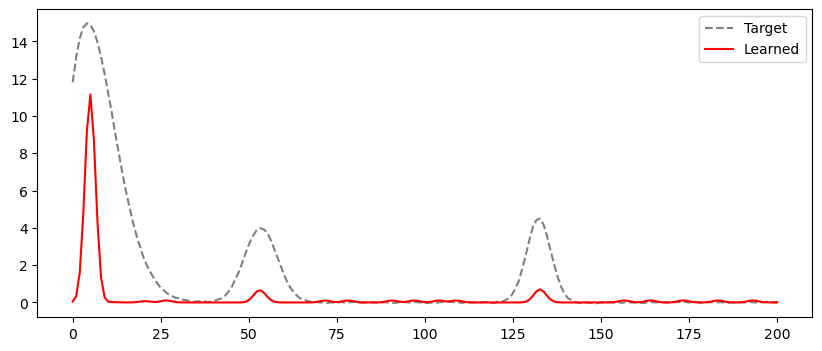

In [21]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. THE STRIPPED-DOWN ENGINE
# ==========================================

def simple_physics_decoder(sources, mics, time_axis):
    """A version with NO learnable alpha to prevent 'The Smear'."""
    # sources: [intensity, x, y, z, t, ...]
    @jax.vmap
    def one_src(s):
        intensity = jax.nn.softplus(s[0])
        dist = jnp.sqrt(jnp.sum((mics - s[1:4])**2, axis=-1) + 1e-6)
        # 1.5 units/ms. We keep a FIXED width of 1.5 to ensure sharpness.
        arrival_times = s[4] + (dist / 1.5) 
        diff = time_axis[:, None] - arrival_times[None, :]
        return intensity * jnp.exp(-0.5 * (diff / 1.5)**2)

    return jnp.sum(one_src(sources), axis=0)

# ==========================================
# 2. THE RECOVERY LOOP
# ==========================================

@jax.jit
def train_step(params, data, time, mics):
    def loss_fn(p):
        pred = simple_physics_decoder(p['sources'], mics, time)
        # Standard MSE - no normalization yet, keep it raw
        return jnp.mean(jnp.square(pred - data)) + 0.01 * jnp.sum(jax.nn.softplus(p['sources'][:, 0]))

    loss, grads = jax.value_and_grad(loss_fn)(params)
    # High-gain updates for Time and Intensity
    grads['sources'] = grads['sources'].at[:, 0].multiply(10.0)
    grads['sources'] = grads['sources'].at[:, 4].multiply(10.0)
    return loss, grads

# ==========================================
# 3. INITIALIZATION (The Panoramic Sweep)
# ==========================================

# We use the grid, but we spread them out in time explicitly
time_sweep = jnp.linspace(0, 200, 25)
learning_params = {
    'sources': jnp.zeros((25, 8)).at[:, 1:4].set(grid)
                                 .at[:, 0].set(1.0) # START VISIBLE
                                 .at[:, 4].set(time_sweep)
}

optimizer = optax.adam(0.05) # Aggressive learning
opt_state = optimizer.init(learning_params)

# ==========================================
# 4. RUN
# ==========================================

def convexity_sucking_loss(sources, time_axis):
    # intensities: (N,)
    intensities = jax.nn.softplus(sources[:, 0])
    # times: (N,)
    t_coords = sources[:, 4]
    
    # Calculate a 'Distance Matrix' in time between all potential sources
    # This represents how much their Gaussians overlap
    time_diffs = t_coords[:, None] - t_coords[None, :]
    
    # The 'Sucking' Kernel: High value if sources are close in time
    # We use a width that favors 'Wider' contributions
    overlap_kernel = jnp.exp(-0.5 * jnp.square(time_diffs / 10.0))
    
    # The Penalty: Intensity_i * Intensity_j * Overlap_ij
    # This is a quadratic form that is minimized when only one 
    # source is active in a given 'neighborhood'.
    sucking_force = jnp.dot(intensities, jnp.dot(overlap_kernel, intensities))
    
    # We subtract the self-overlap (diagonal) so we don't punish 
    # a source for existing, only for having roommates.
    self_overlap = jnp.sum(jnp.square(intensities))
    return sucking_force - self_overlap

@jax.jit
def train_step_vortex(p, data, time, mics):
    def loss_fn(params):
        pred = simple_physics_decoder(params['sources'], mics, time)
        recon = jnp.mean(jnp.square(pred - data))
        
        # 1. Standard Sparsity (The 'Outer' Quantizer)
        sparsity = 0.05 * jnp.sum(jax.nn.softplus(params['sources'][:, 0]))
        
        # 2. THE SUCKING FORCE (The 'Inner' Convexity factor)
        # This favors one big wide peak over many small steep ones.
        sucking = 0.1 * convexity_sucking_loss(params['sources'], time)
        
        return recon + sparsity + sucking

    loss, grads = jax.value_and_grad(loss_fn)(p)
    
    # Increase the 'Sucking' gradient for the first event
    grads['sources'] = grads['sources'].at[:, 0].multiply(30.0)
    grads['sources'] = grads['sources'].at[:, 4].multiply(100.0)
    
    return loss, grads
    

# Run for 200 'Smoothing' iterations
print("Running Final Smoothing Pass...")
for i in range(201):
    loss_val, grads = train_step_vortex(learning_params, mic_data, time_axis, true_mic_pos)
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
# Final Plot
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.5, label="Target")
plt.plot(time_axis, simple_physics_decoder(learning_params['sources'], true_mic_pos, time_axis)[:, 0], 'r', label="Learned")
plt.legend(); plt.show()

Running Tensor-Broadcasting Discovery...
Iter 0000 | Loss: 1.157965
Iter 0200 | Loss: 0.012166
Iter 0400 | Loss: 0.008602
Iter 0600 | Loss: 0.007738
Iter 0800 | Loss: 0.007371
Iter 1000 | Loss: 0.007175


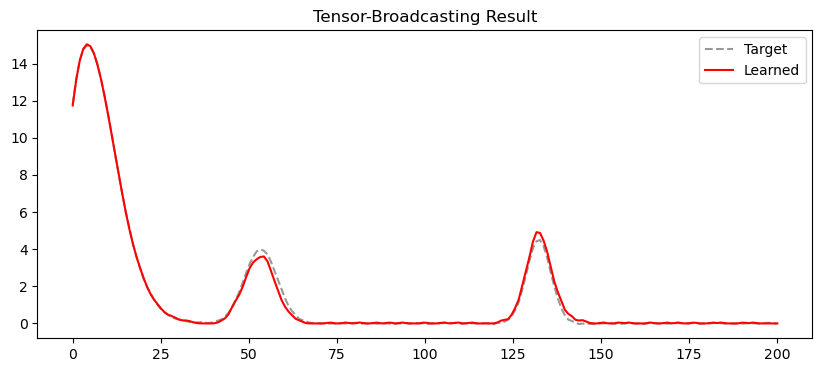

In [29]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

# ==========================================
# 1. ROBUST TENSOR DECODER
# ==========================================

def fast_tensor_decoder(sources, mics, time_axis):
    """
    Computes acoustic streams using explicit broadcasting.
    sources: (N_src, 6) -> [intensity, x, y, z, t, width]
    mics: (N_mic, 3)
    time_axis: (T,)
    """
    # 1. Extract and constrain parameters
    amp = jax.nn.softplus(sources[:, 0])  # (N_src,)
    pos = sources[:, 1:4]                 # (N_src, 3)
    t0  = sources[:, 4]                   # (N_src,)
    w   = jax.nn.softplus(sources[:, 5]) + 0.5 # (N_src,)

    # 2. Calculate Distances: (N_src, N_mic)
    # Using expansion: (N_src, 1, 3) - (1, N_mic, 3)
    diff_pos = pos[:, None, :] - mics[None, :, :]
    dist = jnp.sqrt(jnp.sum(jnp.square(diff_pos), axis=-1) + 1e-6)

    # 3. Calculate Arrival Times: (N_src, N_mic)
    arrival = t0[:, None] + (dist / 1.5)

    # 4. Generate Pulses: (N_src, N_mic, T)
    # Time expansion: (1, 1, T) - (N_src, N_mic, 1)
    # This creates a huge 3D tensor that represents every possible interaction
    time_diff = time_axis[None, None, :] - arrival[:, :, None]
    
    # Broadcast widths: (N_src, 1, 1)
    pulses = amp[:, None, None] * jnp.exp(-0.5 * jnp.square(time_diff / w[:, None, None]))
    
    # 5. Sum across sources to get (N_mic, T), then transpose to (T, N_mic)
    return jnp.sum(pulses, axis=0).T

# ==========================================
# 2. THE LOG-DOMAIN TRAIN STEP
# ==========================================

@jax.jit
def train_step(p, data, time, mics):
    def loss_fn(params):
        pred = fast_tensor_decoder(params['sources'], mics, time)
        # log1p(x) = log(1+x), keeps the gradients active even for small values
        return jnp.mean(jnp.square(jnp.log1p(pred) - jnp.log1p(data)))

    loss, grads = jax.value_and_grad(loss_fn)(p)
    # Apply a global 'wake-up' multiplier to the source parameters
    grads['sources'] = jax.tree_util.tree_map(lambda x: x * 50.0, grads['sources'])
    return loss, grads

# ==========================================
# 3. THE "MOUNTAIN OF SOUND" INITIALIZATION
# ==========================================

# 50 sources to blanket the 200ms timeline
init_t = jnp.linspace(0, 200, 50)
sources = jnp.zeros((50, 6))
sources = sources.at[:, 1:4].set(0.0) # Start all at the origin
sources = sources.at[:, 0].set(2.0)   # Start LOUD (softplus(2) ~ 2.1)
sources = sources.at[:, 4].set(init_t)
sources = sources.at[:, 5].set(1.0)   # Reasonable initial width

learning_params = {'sources': sources}
optimizer = optax.adam(0.05)
opt_state = optimizer.init(learning_params)

# ==========================================
# 4. EXECUTION
# ==========================================

print("Running Tensor-Broadcasting Discovery...")
for i in range(1001):
    # Note: Ensure mic_data, time_axis, and true_mic_pos are in scope
    loss_val, grads = train_step(learning_params, mic_data, time_axis, true_mic_pos)
    updates, opt_state = optimizer.update(grads, opt_state)
    learning_params = optax.apply_updates(learning_params, updates)
    
    if i % 200 == 0:
        print(f"Iter {i:04d} | Loss: {loss_val:.6f}")

# Visual Confirmation
plt.figure(figsize=(10, 4))
plt.plot(time_axis, mic_data[:, 0], 'k--', alpha=0.4, label="Target")
final_pred = fast_tensor_decoder(learning_params['sources'], true_mic_pos, time_axis)
plt.plot(time_axis, final_pred[:, 0], 'r', label="Learned")
plt.legend(); plt.title("Tensor-Broadcasting Result"); plt.show()

In [30]:
def verify_inner_quantization(params, threshold=0.1):
    intensities = jax.nn.softplus(params['sources'][:, 0])
    # Find indices where intensity is above threshold
    active_indices = jnp.where(intensities > threshold)[0]
    
    print(f"{'Index':<8} | {'Intensity':<12} | {'X Coord':<10} | {'Y Coord':<10} | {'Time'}")
    print("-" * 60)
    for idx in active_indices:
        s = params['sources'][idx]
        print(f"{int(idx):<8} | {float(intensities[idx]):<12.4f} | {float(s[1]):<10.2f} | {float(s[2]):<10.2f} | {float(s[4]):.2f}")

verify_inner_quantization(learning_params)

Index    | Intensity    | X Coord    | Y Coord    | Time
------------------------------------------------------------
0        | 5.0571       | -0.98      | 1.26       | 1.08
1        | 4.7607       | 0.19       | -0.30      | -0.18
2        | 4.7031       | 0.23       | -0.34      | 4.35
3        | 4.5753       | -0.06      | 0.01       | 8.38
4        | 4.2130       | -0.01      | 0.01       | 13.31
5        | 0.7920       | -0.18      | -0.10      | 19.60
6        | 0.4763       | -0.27      | -0.03      | 23.82
7        | 0.2918       | -2.52      | -0.43      | 26.30
8        | 0.1451       | -3.90      | -1.48      | 29.14
9        | 0.1513       | -3.86      | -2.91      | 38.72
10       | 0.2477       | -3.11      | -1.53      | 42.57
11       | 0.8098       | 0.13       | 1.00       | 46.07
12       | 2.3339       | -0.05      | 0.09       | 49.93
13       | 3.2765       | -0.43      | -2.92      | 51.11
14       | 0.6750       | -0.06      | -1.74      | 55.77
15       | 0.47